# Trabajo Práctico N° 3

In [8]:
%matplotlib inline
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os

## 1.

Text(0.5, 1.0, 'Template')

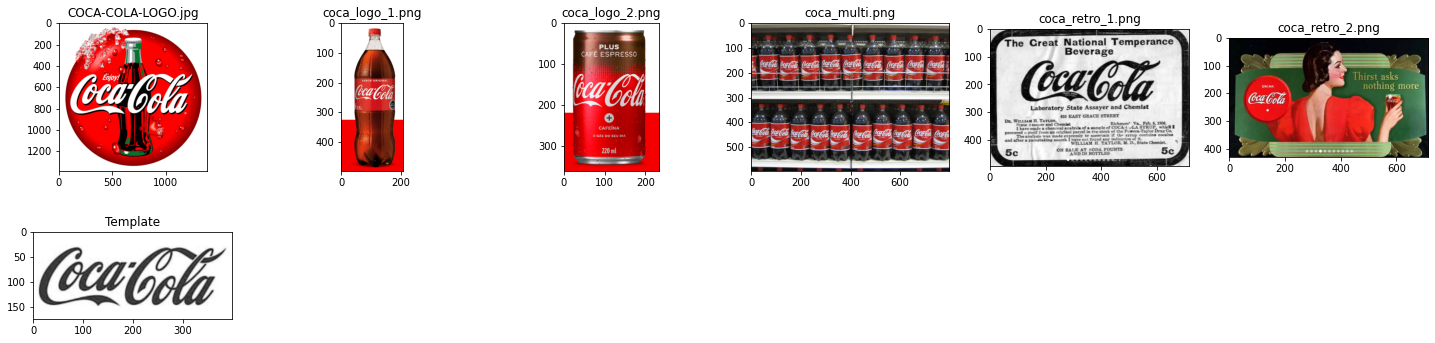

In [9]:
nombresImagenes = os.listdir(f'images/')
imagenes = [cv.cvtColor(cv.imread(f'images/'+ i), cv.COLOR_BGR2RGB) for i in nombresImagenes]
template = cv.imread(f'template/pattern.png',0)

plt.figure(figsize=(25,6))
plt.subplot(2,6,1)
plt.title(nombresImagenes[0])
plt.imshow(imagenes[0])
plt.subplot(2,6,2)
plt.title(nombresImagenes[1])
plt.imshow(imagenes[1])
plt.subplot(2,6,3)
plt.title(nombresImagenes[2])
plt.imshow(imagenes[2])
plt.subplot(2,6,4)
plt.title(nombresImagenes[3])
plt.imshow(imagenes[3])
plt.subplot(2,6,5)
plt.title(nombresImagenes[4])
plt.imshow(imagenes[4])
plt.subplot(2,6,6)
plt.title(nombresImagenes[5])
plt.imshow(imagenes[5])

plt.subplot(2,6,7)
plt.imshow(template,cmap="gray")
plt.title('Template')


Análisis Exploratorio:
 - Las imágenes tienen distintas escalas y el tamaño de sus logos es diferente al del template.
 - Diferentes fondos.
 - La imagen "coca_multi.png" tiene los logos en muy baja resolución por lo que sería difícil detectarlos. Se aplica un resize para aumentar el tamaño de esta imagen.

Decido hacer un procesamiento también al template para poder trabajar con él.

Dimensiones del template: (70, 160)


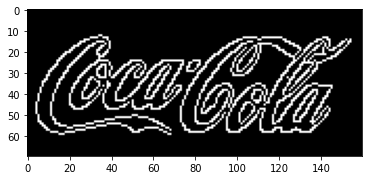

In [10]:
imagenes[3] = cv.resize(imagenes[3], None, fx=2, fy=2)

template_edges = cv.Canny(cv.resize(template, None, fx=0.4, fy=0.4), 25, 100, L2gradient=True) 
(tH, tW) = template_edges.shape[:2]
plt.imshow(template_edges, cmap='gray')
print("Dimensiones del template: {}".format(template_edges.shape))

Me queda un template de bordes a primera vista más pequeño que el logo más pequeño (ojímetro) de las imágenes.

Template matching no es invariante a escalas por lo que necesito crear una función para poder utilizar esta técnica independientemente de las escalas de los logos.

In [21]:
def scaleInvariantLogoDetection(img, template, visualize=False, multidetection_threshold= None,  canny_th1=50, canny_th2=200):

	# Creo variable para guardar coincidencias entre imagenes y el template
	coincidencia_max = None
	img_salida = img.copy()
	img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

	# Hago un loop para aplicar template matching para diferentes escalas de la imagen
	for scale in np.linspace(0.05, 1.0, 50)[::-1]:
		
		# Reduzco el tamaño de la imagen y guardo la relación entre el tamaño original y el reducido (ratio)
		resized = cv.resize(img_gray, None, fx=scale, fy=scale)
		ratio = img_gray.shape[1] / float(resized.shape[1])

		# Si el template es más grande que la imagen reducida, quiebro el loop
		if resized.shape[0] < tH or resized.shape[1] < tW:
			break

		# Aplico Canny a la imagen para trabajar con bordes
		edged = cv.Canny(resized, canny_th1, canny_th2)
		
		# Aplico template matching y guardo los valores de correlación y de posición del máximo
		result = cv.matchTemplate(edged, template, cv.TM_CCORR_NORMED)
		(_, maxVal, _, maxLoc) = cv.minMaxLoc(result)
		
		
		if visualize:
			clon = edged.copy()


			# Dibujo una bounding box en la posición de máxima correlación
			cv.rectangle(clon, maxLoc, (maxLoc[0] + tW, maxLoc[1] + tH), (255, 0, 0), 2)
			cv.imshow("maxVal = {}".format(maxVal),clon)
			cv.waitKey(0)
			cv.destroyAllWindows()

		# Guardo este máximo y el ratio si es mejor que los hallados en iteraciones anteriores
		if coincidencia_max is None or maxVal > coincidencia_max[0]:
			coincidencia_max = (maxVal, maxLoc, ratio, scale)

	# De todas las iteraciones obtengo la mejor detección y dibujo una bounding box escalada al tamaño original de la imagen
	(_, maxLoc, ratio, _) = coincidencia_max
	(startX, startY) = (int(maxLoc[0] * ratio), int(maxLoc[1] * ratio))
	(endX, endY) = (int((maxLoc[0] + tW) * ratio), int((maxLoc[1] + tH) * ratio))

	cv.rectangle(img_salida, (startX, startY), (endX, endY), (0, 0, 255), 4)
	cv.putText(img_salida, str(coincidencia_max[0]), (startX, startY-4),
                    cv.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)
	#plt.imshow(img_salida)
	#print(coincidencia_max[0])
	#cv.waitKey(0)
	return img_salida, coincidencia_max[0], coincidencia_max[3]

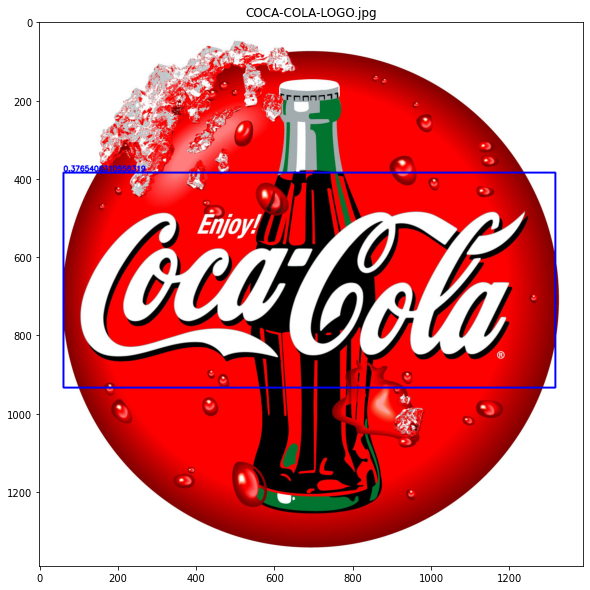

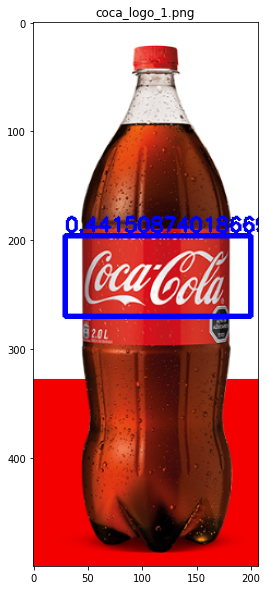

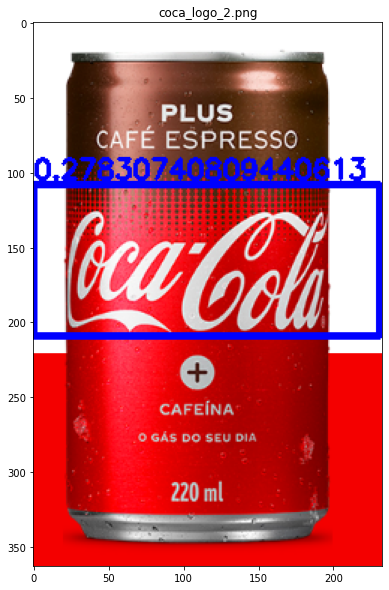

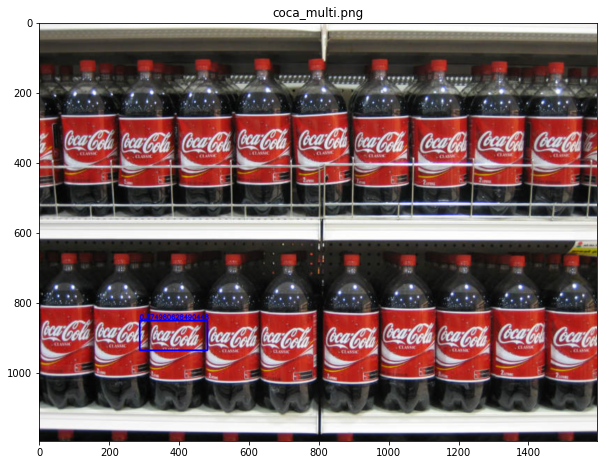

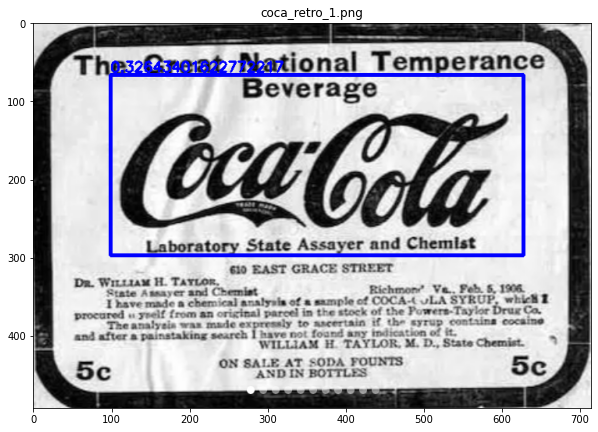

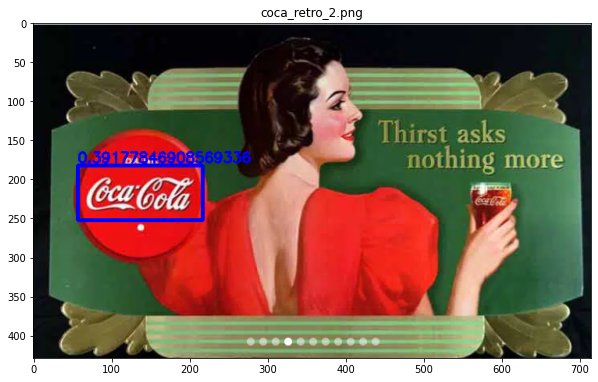

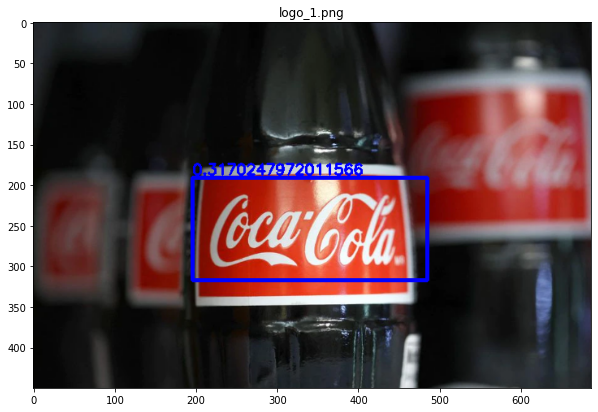

In [22]:
for i,imagen in enumerate(imagenes):
    plt.figure(figsize=(10,10))
    plt.title(nombresImagenes[i])
    plt.imshow(scaleInvariantLogoDetection(imagen,template_edges)[0])
    

## 2 y 3.

Tomé prestado un [algoritmo de internet](http://ronny.rest/tutorials/module/localization_001/iou/) para obtener las Intersections over Unions y lo adapté a mi código para poder deshacerme de los duplicados más adelante.

In [112]:
def get_iou(a, b, epsilon=1e-5):
    """ Given two boxes `a` and `b` defined as a list of four numbers:
            [x1,y1,x2,y2]
        where:
            x1,y1 represent the upper left corner
            x2,y2 represent the lower right corner
        It returns the Intersect of Union score for these two boxes.

    Args:
        a:          (list of 4 numbers) [x1,y1,x2,y2]
        b:          (list of 4 numbers) [x1,y1,x2,y2]
        epsilon:    (float) Small value to prevent division by zero

    Returns:
        (float) The Intersect of Union score.
    """
    # COORDINATES OF THE INTERSECTION BOX
    x1 = max(a["TOP_LEFT_X"], b["TOP_LEFT_X"])
    y1 = max(a["TOP_LEFT_Y"], b["TOP_LEFT_Y"])
    x2 = min(a["BOTTOM_RIGHT_X"], b["BOTTOM_RIGHT_X"])
    y2 = min(a["BOTTOM_RIGHT_Y"], b["BOTTOM_RIGHT_Y"])

    # AREA OF OVERLAP - Area where the boxes intersect
    width = (x2 - x1)
    height = (y2 - y1)
    # handle case where there is NO overlap
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height

    # COMBINED AREA
    area_a = (a["BOTTOM_RIGHT_X"] - a["TOP_LEFT_X"]) * (a["BOTTOM_RIGHT_Y"] - a["TOP_LEFT_Y"])
    area_b = (b["BOTTOM_RIGHT_X"] - b["TOP_LEFT_X"]) * (b["BOTTOM_RIGHT_Y"] - b["TOP_LEFT_Y"])
    area_combined = area_a + area_b - area_overlap

    # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
    iou = area_overlap / (area_combined+epsilon)
    return iou

In [115]:
def scaleInvariantMultiLogoDetection(img, template, visualize=False, multidetection_threshold= None,  canny_th1=50, canny_th2=200):

	# Creo variable para guardar coincidencias entre imagenes y el template
	coincidencia_max = None
	img_salida = img.copy()
	img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)


	# Hago un loop para aplicar template matching para diferentes escalas de la imagen
	for scale in np.linspace(0.1, 1.0, 40)[::-1]:
		
		# Reduzco el tamaño de la imagen y guardo la relación entre el tamaño original y el reducido (ratio)
		resized = cv.resize(img_gray, None, fx=scale, fy=scale)
		ratio = img_gray.shape[1] / float(resized.shape[1])

		# Si el template es más grande que la imagen reducida, quiebro el loop
		if resized.shape[0] < tH or resized.shape[1] < tW:
			break

		# Aplico Canny a la imagen para trabajar con bordes
		edged = cv.Canny(resized, canny_th1, canny_th2)
		
		# Aplico template matching y guardo los valores de correlación y de posición del máximo
		result = cv.matchTemplate(edged, template, cv.TM_CCORR_NORMED)

		
		clon = edged.copy()

		# Encuentro los puntos donde el resultado de la correlación es mayor o igual al umbral elegido
		threshold = multidetection_threshold
		match_locations = np.where( result >= threshold)

		# Creo un contador para contar los matches y una lista para almacenarlos
		contador=0
		puntos =[]

		for (x, y) in zip(match_locations[1], match_locations[0]):
			match = {
        	    "TOP_LEFT_X": x,
        	    "TOP_LEFT_Y": y,
        	    "BOTTOM_RIGHT_X": x + tW,
        	    "BOTTOM_RIGHT_Y": y + tH,
        	    "MATCH_VALUE": result[y, x],
        	}
			puntos.append(match)
			contador = contador+1


		# Elimino duplicados
		non_max_suppression_threshold= 0.5
		sorted_puntos = sorted(puntos, key=lambda punto: punto['MATCH_VALUE'], reverse=True)
		filtered_puntos = []
		for punto_ in sorted_puntos:
			overlap_found = False
			for filtered_punto in filtered_puntos:
				iou = get_iou(punto_, filtered_punto)
				if iou > non_max_suppression_threshold:
					overlap_found = True
					break
			if not overlap_found:
				filtered_puntos.append(punto_)

		# Creo las bounding boxes para los matches filtrados
		for detection in filtered_puntos:
			cv.rectangle(clon,
		    (detection["TOP_LEFT_X"], detection["TOP_LEFT_Y"]),
		    (detection["BOTTOM_RIGHT_X"], detection["BOTTOM_RIGHT_Y"]),
		   	(255,0,0), 2)

			cv.putText(clon, 
		    f"{detection['MATCH_VALUE']}",
		    (detection["TOP_LEFT_X"] + 2, detection["TOP_LEFT_Y"] - 10),
		    cv.FONT_HERSHEY_SIMPLEX,
		    0.5,
		    (255,0,255),2)

		# Dejo esta opción para ver el proceso paso a paso de ser necesario
		if visualize:
			cv.imshow(f"{contador}",clon)
			cv.waitKey(0)
			cv.destroyAllWindows()

		# Guardo la iteración con mayor cantidad de matchings y el ratio 
		if coincidencia_max is None or contador > coincidencia_max[0]:
			coincidencia_max = (contador, filtered_puntos, ratio)

	# De todas las iteraciones obtengo la mejor y dibujo una bounding boxes escaladas al tamaño original de la imagen
	_, puntos, ratio = coincidencia_max

	for detection in puntos:
		cv.rectangle(img_salida, 
			(int(detection["TOP_LEFT_X"]*ratio), int(detection["TOP_LEFT_Y"]*ratio)),
			(int(detection["BOTTOM_RIGHT_X"]*ratio), int(detection["BOTTOM_RIGHT_Y"]*ratio)),
			(0,0,255), int(2*ratio))
		cv.putText(img_salida, 
		    f"{detection['MATCH_VALUE']}",
		    (int(detection["TOP_LEFT_X"]*ratio) + 2, int(detection["TOP_LEFT_Y"]*ratio) - 10),
		    cv.FONT_HERSHEY_SIMPLEX,
		    0.75,
		    (0,0,255),
		    2)

	return img_salida

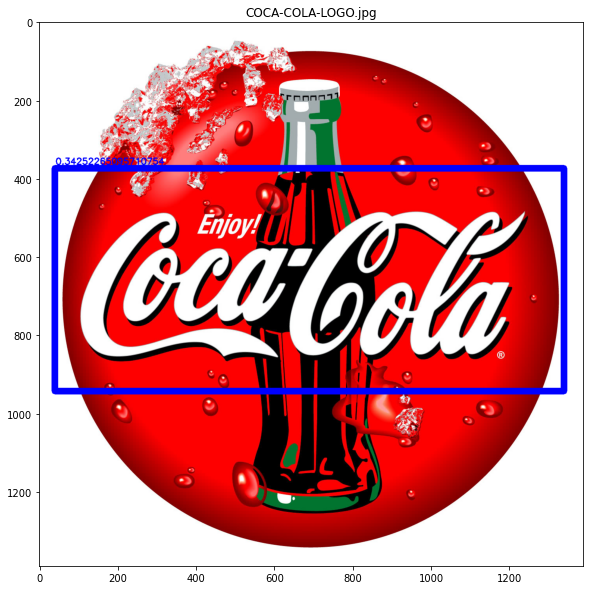

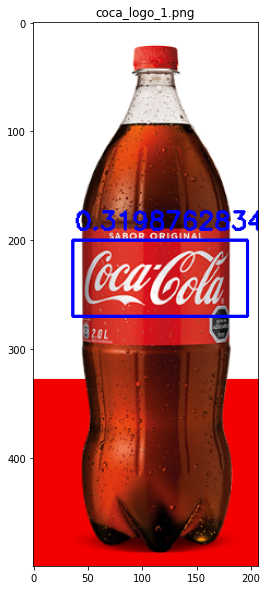

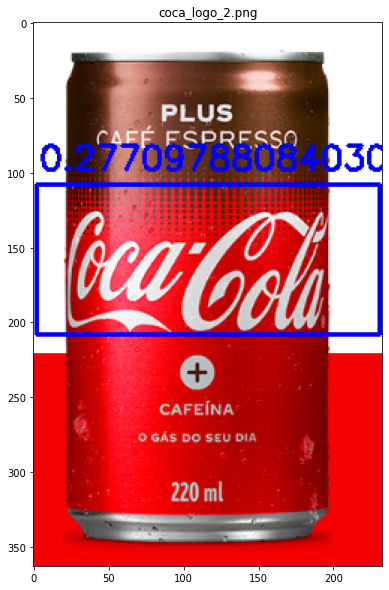

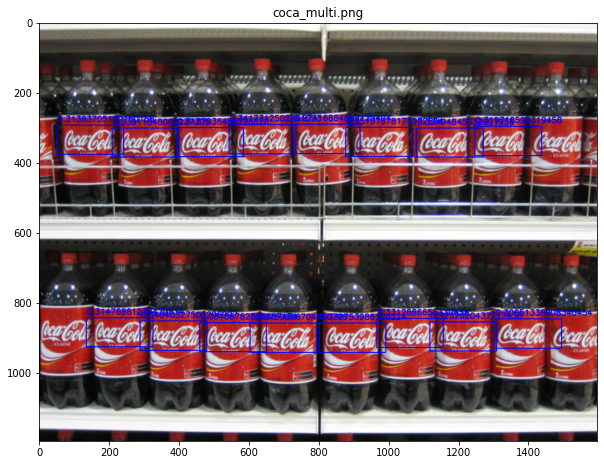

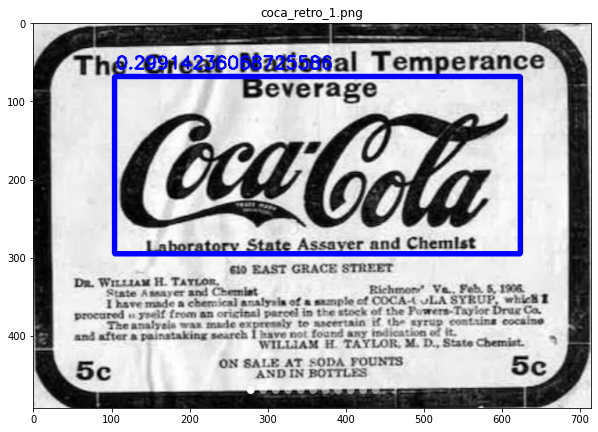

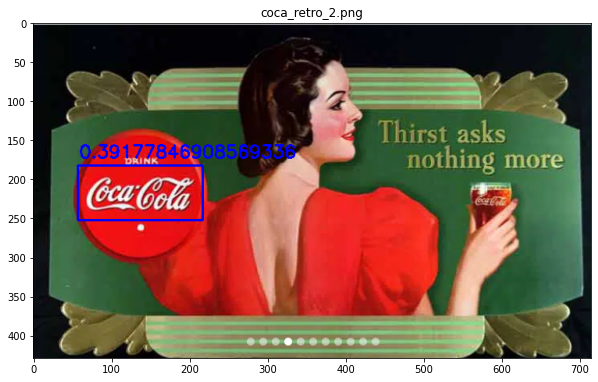

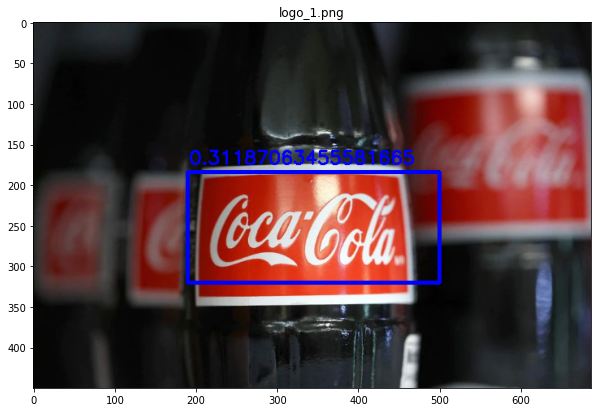

In [116]:
for i,imagen in enumerate(imagenes):
    plt.figure(figsize=(10,10))
    plt.title(nombresImagenes[i])
    plt.imshow(scaleInvariantMultiLogoDetection(imagen,template_edges, multidetection_threshold=0.27))